<a href="https://colab.research.google.com/github/james-yu2005/Affi-NN-ity/blob/main/PDBBindV1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [61]:
!pip install -q rdkit-pypi torch-geometric pandas tqdm deepchem fair-esm biopython torch

In [81]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from torch.nn import Linear, ReLU, Sequential, BatchNorm1d, Dropout
import torch_geometric
from torch_geometric.data import Dataset, Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GINConv, global_add_pool
from rdkit import Chem
from rdkit.Chem import Draw
import deepchem as dc
import esm
from tqdm import tqdm
from Bio import PDB
from sklearn.metrics import mean_squared_error, r2_score
from collections import Counter
import matplotlib.pyplot as plt
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

In [82]:
amino_acid_to_idx = {
    'A': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6,
    'H': 7, 'I': 8, 'K': 9, 'L': 10, 'M': 11, 'N': 12,
    'P': 13, 'Q': 14, 'R': 15, 'S': 16, 'T': 17, 'V': 18,
    'W': 19, 'Y': 20
}

In [83]:
tasks, datasets, transformers = dc.molnet.load_pdbbind(
    featurizer='raw',
    set_name='refined',
    splitter='random',
    reload=True
)
train_dataset, valid_dataset, test_dataset = datasets
print(f"Train dataset length: {len(train_dataset)}\nValidate dataset length: {len(valid_dataset)}\nTest dataset length: {len(test_dataset)}")

Train dataset length: 3881
Validate dataset length: 485
Test dataset length: 486


In [84]:
for X, y, w, ids in train_dataset.iterbatches(batch_size=1, deterministic=True):
    print("Example of first datum from training :\n")
    print("Input features (X):", X)
    print("Binding affinity target label (y):", y)
    print("Weight (w):", w)
    print("Sample ID (ids):", ids)
    break

Example of first datum from training :

Input features (X): [['/tmp/refined-set/2wgj/2wgj_ligand.sdf'
  '/tmp/refined-set/2wgj/2wgj_pocket.pdb']]
Binding affinity target label (y): [1.17136862]
Weight (w): [1.]
Sample ID (ids): ['2wgj']


In [85]:
def remove_invalid_molecules(dc_dataset, dataset_name):
    valid_entries = []
    removed = 0
    for X, y, w, ids in dc_dataset.iterbatches(batch_size=1, deterministic=True):
      ligand_path = X[0][0]
      ligand_mol = Chem.MolFromMolFile(str(ligand_path))

      if ligand_mol is None:
        if str(dataset_name) == "train":
          removed += 1
        elif str(dataset_name) == "valid":
          removed += 1
        elif str(dataset_name) == "test":
          removed += 1
        continue

      valid_entries.append((X, y, w, ids))

    return valid_entries, removed

clean_train_dataset, train_removed = remove_invalid_molecules(train_dataset, "train")
clean_valid_dataset, valid_removed = remove_invalid_molecules(valid_dataset, "valid")
clean_test_dataset, test_removed = remove_invalid_molecules(test_dataset, "test")

print(f"New train dataset length: {len(clean_train_dataset)}. Removed molecules: {train_removed}\nNew validate dataset length: {len(clean_valid_dataset)}. Removed molecules: {valid_removed}\nNew test dataset length: {len(clean_test_dataset)}. Removed molecules: {test_removed}")
print(f"Example of first datum after cleaning:\n")

New train dataset length: 2562. Removed molecules: 1319
New validate dataset length: 334. Removed molecules: 151
New test dataset length: 310. Removed molecules: 176
Example of first datum after cleaning:



In [86]:
def get_all_protein_lengths(dataset):
  parser = PDB.PDBParser(QUIET=True)
  molecule_protein_lengths = []
  for X, y, w, ids in dataset:
    protein_path = X[0][1]
    structure = parser.get_structure("protein", protein_path)
    ppb = PDB.PPBuilder()
    sequence = ""
    for pp in ppb.build_peptides(structure):
        sequence += str(pp.get_sequence())
        length = len(str(sequence))
    molecule_protein_lengths.append(length)

  return molecule_protein_lengths

def get_all_ligand_lengths(dataset):
  molecule_ligand_lengths = []
  for X, y, w, ids in dataset:
    ligand_path = X[0][0]
    ligand_mol = Chem.MolFromMolFile(str(ligand_path))
    ligand_smiles = Chem.MolToSmiles(ligand_mol)
    length = len(str(ligand_smiles))
    molecule_ligand_lengths.append(length)

  return molecule_ligand_lengths

ligand_train_length_dataset = get_all_ligand_lengths(clean_train_dataset)
ligand_valid_length_dataset = get_all_ligand_lengths(clean_valid_dataset)
ligand_test_length_dataset = get_all_ligand_lengths(clean_test_dataset)
protein_train_length_dataset = get_all_protein_lengths(clean_train_dataset)
protein_valid_length_dataset = get_all_protein_lengths(clean_valid_dataset)
protein_test_length_dataset = get_all_protein_lengths(clean_test_dataset)

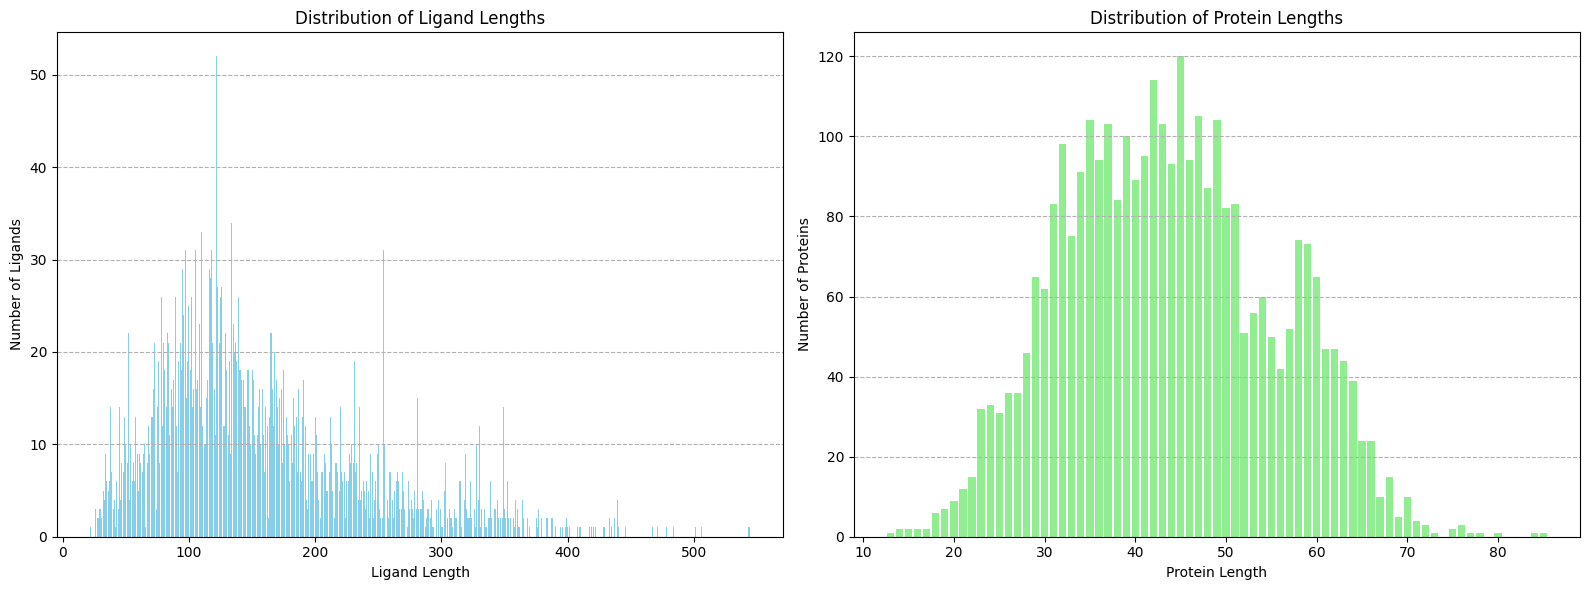

Max ligand length: 544
90% of ligands are shorter than or equal to: 275
Max protein length: 85
90% of proteins are shorter than or equal to: 60


In [87]:
## Combine all ligand lengths
all_ligand_lengths = ligand_train_length_dataset + ligand_valid_length_dataset + ligand_test_length_dataset
ligand_length_counts = Counter(all_ligand_lengths)
ligand_lengths = sorted(ligand_length_counts.keys())
ligand_counts = [ligand_length_counts[length] for length in ligand_lengths]

## Combine all protein lengths
all_protein_lengths = protein_train_length_dataset + protein_valid_length_dataset + protein_test_length_dataset
protein_length_counts = Counter(all_protein_lengths)
protein_lengths = sorted(protein_length_counts.keys())
protein_counts = [protein_length_counts[length] for length in protein_lengths]

fig, axs = plt.subplots(1, 2, figsize=(16, 6))

## Ligand plot
axs[0].bar(ligand_lengths, ligand_counts, color='skyblue')
axs[0].set_xlabel('Ligand Length')
axs[0].set_ylabel('Number of Ligands')
axs[0].set_title('Distribution of Ligand Lengths')
axs[0].grid(axis='y', linestyle='--')

## Protein plot
axs[1].bar(protein_lengths, protein_counts, color='lightgreen')
axs[1].set_xlabel('Protein Length')
axs[1].set_ylabel('Number of Proteins')
axs[1].set_title('Distribution of Protein Lengths')
axs[1].grid(axis='y', linestyle='--')

plt.tight_layout()
plt.show()

## Stats for ligand
max_ligand = max(all_ligand_lengths)
ligand_cutoff = int(np.percentile(all_ligand_lengths, 90))
print(f"Max ligand length: {max_ligand}")
print(f"90% of ligands are shorter than or equal to: {ligand_cutoff}")

## Stats for protein
max_protein = max(all_protein_lengths)
protein_cutoff = int(np.percentile(all_protein_lengths, 90))
print(f"Max protein length: {max_protein}")
print(f"90% of proteins are shorter than or equal to: {protein_cutoff}")

In [88]:
def get_node_features(mol): # node features are atoms
    '''Iterates over all atoms in a molecule and creates a feature vector/tensor'''
    all_node_feats = []
    for atom in mol.GetAtoms():
        # node_feat_dim = 9
        node_features = [
            atom.GetAtomicNum(), # Atomic number (e.g., C=6, O=8).
            atom.GetDegree(), # Number of directly bonded neighbors.
            atom.GetFormalCharge(), # Formal charge on the atom.
            int(atom.GetHybridization()),  # convert enum to int, Hybridization type encoded as integer (sp, sp2, sp3).
            atom.GetIsAromatic(), # Boolean: is it part of an aromatic ring?
            atom.GetTotalNumHs(), # Total number of attached hydrogens.
            atom.GetNumRadicalElectrons(), # Number of unpaired electrons
            atom.IsInRing(), # 	Boolean: is it part of any ring?
            int(atom.GetChiralTag())  # convert enum to int: 	Encodes chirality (R/S configuration).
        ]
        all_node_feats.append(node_features)
    return torch.tensor(all_node_feats, dtype=torch.float)

def get_edge_features(mol): # edge features are bonds
    '''Iterates over all edges in a molecule and returns a feature vector/tensor'''
    all_edge_feats = []
    for bond in mol.GetBonds():
        edge_feats = [
            bond.GetBondTypeAsDouble(), # Bond type as float (single=1, double=2, etc.).
            bond.IsInRing() # Boolean: is bond part of a ring?
        ]
        all_edge_feats += [edge_feats, edge_feats]  # Adds each edge twice ([i → j] and [j → i]) to make the graph bidirectional, which is important for GNNs
    return torch.tensor(all_edge_feats, dtype=torch.float)

def get_adjacency_info(mol):
    '''
    PyTorch Geometric represents a graph's connectivity using an edge index tensor, wich sotores pairs of connected node indices
    In a GNN each node updates its state based on its connected neighbours. Without connectivity info, the model wouldn't know how atoms are bonded
    Shape: [2 rows representing source and target node, num_edges columns]
    '''
    edge_indices = []
    for bond in mol.GetBonds():
        i, j = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
        edge_indices += [[i, j], [j, i]]  # Bidirectional edges
    return torch.tensor(edge_indices, dtype=torch.long).t().contiguous() # transpose because PyTorch Geometric expects a certain format, contiguous for GPU goodness

In [89]:
def extract_lettered_sequence_from_pdb(pdb_path):
    """Extracts the amino acid sequence from a PDB file using Biopython."""
    parser = PDB.PDBParser(QUIET=True)
    structure = parser.get_structure("protein", pdb_path)

    ppb = PDB.PPBuilder() # PPBuilder: Builds polypeptides from the structure (continuous stretches of amino acids).

    sequence = ""
    for pp in ppb.build_peptides(structure): # build_peptides(structure): Returns a list of polypeptides found in the structure.
        sequence += str(pp.get_sequence()) # get_sequence(): Extracts the sequence of amino acids as a string (e.g., "MKTLLILT").
    return sequence

def encode_sequence_to_num(sequence, required_length=100):
    ''' Encodes the lettered amino acid sequence to numbered format via mapping with truncation/zero-filling as needed'''
    encoded_sequence = [amino_acid_to_idx.get(amino_acid, 0) for amino_acid in sequence]  # 0 for unknowns
    if len(encoded_sequence) < required_length:
        return encoded_sequence + [0] * (required_length - len(encoded_sequence))
    return encoded_sequence[:required_length]

In [90]:
def get_max_protein_sequence_length():
    '''
    Iterates over all samples in the train_dataset and:
    - extracts the protein sequence from each sample's PDB file
    - tracks and returns the max sequence length across the dataset
    '''
    max_len = 0
    molecule_data = []

    for X, y, w, ids in train_dataset.iterbatches(batch_size=1, deterministic=True):
        protein_path = X[0][1]
        lettered_protein_sequence = extract_lettered_sequence_from_pdb(protein_path)
        max_len = max(max_len, len(lettered_protein_sequence))
        # print(f"Protein path: {protein_path}")
    return max_len

get_max_protein_sequence_length()

97

In [93]:
def process_deepchem_dataset(dataset):
    ligand_protein_data = []

    for X, y, w, ids in dataset.iterbatches(batch_size=1, deterministic=True):
        ligand_path = X[0][0]
        # print(f"Ligard path: {ligand_path}")

        protein_path = X[0][1]
        # print(f"Protein path: {protein_path}")

        ligand_mol = Chem.MolFromMolFile(str(ligand_path))

        if ligand_mol is None:
          # print(f"Failed to load ligand molecule from {ligand_path}")
          continue  # Skip this sample

        node_features = get_node_features(ligand_mol)
        edge_features = get_edge_features(ligand_mol)
        adjacency_info = get_adjacency_info(ligand_mol)

        lettered_protein_sequence = extract_lettered_sequence_from_pdb(protein_path)
        protein_features_num = encode_sequence_to_num(lettered_protein_sequence)
        protein_features_num_tensor = torch.tensor(protein_features_num, dtype=torch.long).unsqueeze(0)

        data = Data(
            x=node_features,                     # atom features (PyG expects x)
            edge_index=adjacency_info,           # graph edges (PyG expects edge_index)
            edge_attr=edge_features,             # bond features
            y=torch.tensor(y, dtype=torch.float) # target label
        )

        data.protein_features_num = protein_features_num_tensor
        ligand_protein_data.append(data)

    return ligand_protein_data

In [94]:
train_graphs = process_deepchem_dataset(train_dataset)
valid_graphs = process_deepchem_dataset(valid_dataset)
test_graphs = process_deepchem_dataset(test_dataset)

train_loader = DataLoader(train_graphs, batch_size=32, shuffle=True)
val_loader = DataLoader(valid_graphs, batch_size=32, shuffle=False)
test_loader = DataLoader(test_graphs, batch_size=32, shuffle=False)

In [95]:
print(len(train_graphs))
print(len(valid_graphs))
print(len(test_graphs))

2562
334
310


In [96]:
class GINDrugTargetModel(torch.nn.Module):
    def __init__(self, node_feat_dim=9, pocket_feat_dim=100, hidden_dim=128, output_dim=1):
        super(GINDrugTargetModel, self).__init__()

        self.node_embedding = Sequential(
            Linear(node_feat_dim, hidden_dim), # raw atom's 9-dimenion -> 128-dimension
            ReLU(),
            Linear(hidden_dim, hidden_dim)
        )

        nn1 = Sequential(Linear(hidden_dim, hidden_dim), ReLU(), Linear(hidden_dim, hidden_dim))
        self.convolution_1 = GINConv(nn1) # Graph Isomorphism Network convolution: update node embeddings using neighborhood aggregation
        self.batch_norm_1 = BatchNorm1d(hidden_dim) # normalize embeddings for stability

        nn2 = Sequential(Linear(hidden_dim, hidden_dim), ReLU(), Linear(hidden_dim, hidden_dim))
        self.convolution_2 = GINConv(nn2)
        self.batch_norm_2 = BatchNorm1d(hidden_dim)

        self.pocket_embedding = Sequential(
            Linear(pocket_feat_dim, hidden_dim), # 100 -> 128
            ReLU(),
            Dropout(0.1),
            Linear(hidden_dim, hidden_dim), # 128 -> 128
            ReLU(),
            Linear(hidden_dim, hidden_dim) # 128 -> 128
        )
        self.predictor = Sequential(
            Linear(2 * hidden_dim, hidden_dim), # 2 * 128 -> 128
            ReLU(),
            Dropout(0.2),
            Linear(hidden_dim, hidden_dim // 2),
            ReLU(),
            Linear(hidden_dim // 2, output_dim)
        )

    # In PyTorch Geometric, batch is a mini-batch of graph data created by DataLoader which combines multiple torch_geometric.data.Data objects into one batched object
    # Each molecule-protein pair is turned into a Data object like this:
    # batch.x - node features for all atoms in all graphs in this batch. Shape: [total_nodes, node_feat_dim]
    # batch.edge_index - Edge list describing all bonds in all graphs. Shape: [2, total_edges]
    # batch.edge_attr - Edge features
    # batch.batch - Maps each node to its graph. Shape: [total_nodes]
    # batch.protein_features_num - Protein sequence features for each graph. Shape: [batch_size, pocket_feat_dim]
    # batch.y - Target values (binding affinities). Shape: [batch_size]
    def forward(self, batch):
        x = self.node_embedding(batch.x)
        x = F.relu(self.convolution_1(x, batch.edge_index))
        x = self.batch_norm_1(x)

        x = F.relu(self.convolution_2(x, batch.edge_index))
        x = self.batch_norm_2(x)

        mol_emb = global_add_pool(x, batch.batch) # aggregate all nodes into a single graph embedding
        pocket_emb = self.pocket_embedding(batch.protein_features_num.float())
        result = self.predictor(torch.cat([mol_emb, pocket_emb], dim=1))
        return result

def debug_train_model(model, train_loader, val_loader, num_epochs=1, patience = 10, lr=0.001, device='cpu'):
    print(f"Using {device}")
    model = model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        train_losses = []

        for i, batch in enumerate(train_loader):
            batch = batch.to(device)
            optimizer.zero_grad()
            preds = model(batch).squeeze()
            targets = batch.y.squeeze().float().to(device)
            loss = F.mse_loss(preds, targets)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        model.eval()
        val_losses = []

        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(device)
                preds = model(batch).squeeze()
                targets = batch.y.squeeze().float().to(device)
                loss = F.mse_loss(preds, targets)
                val_losses.append(loss.item())

        train_loss_avg = sum(train_losses) / len(train_losses)
        val_loss_avg = sum(val_losses) / len(val_losses)

        if val_loss_avg < best_val_loss:
          best_val_loss = val_loss_avg
          patience_counter = 0
        else:
          patience_counter += 1
          if patience_counter >= patience:
            print("Early stopping triggered.")
            return model

        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss_avg:.4f} - Val Loss: {val_loss_avg:.4f}")
    return model

model = GINDrugTargetModel(node_feat_dim=9, pocket_feat_dim=100)
debug_model = debug_train_model(model, train_loader, val_loader, num_epochs=200, patience=25,device='cpu')

Using cpu
Epoch 1/200 - Train Loss: 0.9153 - Val Loss: 0.7419
Epoch 2/200 - Train Loss: 0.7384 - Val Loss: 0.7929
Epoch 3/200 - Train Loss: 0.6721 - Val Loss: 1.3533
Epoch 4/200 - Train Loss: 0.6504 - Val Loss: 0.6631
Epoch 5/200 - Train Loss: 0.6681 - Val Loss: 0.6965
Epoch 6/200 - Train Loss: 0.6153 - Val Loss: 0.7273
Epoch 7/200 - Train Loss: 0.6202 - Val Loss: 0.7017
Epoch 8/200 - Train Loss: 0.5494 - Val Loss: 0.5985
Epoch 9/200 - Train Loss: 0.5256 - Val Loss: 0.6535
Epoch 10/200 - Train Loss: 0.5207 - Val Loss: 0.9388
Epoch 11/200 - Train Loss: 0.5145 - Val Loss: 0.6205
Epoch 12/200 - Train Loss: 0.4804 - Val Loss: 1.6307
Epoch 13/200 - Train Loss: 0.4584 - Val Loss: 0.5694
Epoch 14/200 - Train Loss: 0.4682 - Val Loss: 0.7217
Epoch 15/200 - Train Loss: 0.4347 - Val Loss: 0.5701
Epoch 16/200 - Train Loss: 0.4449 - Val Loss: 0.5643
Epoch 17/200 - Train Loss: 0.4248 - Val Loss: 0.6812
Epoch 18/200 - Train Loss: 0.3965 - Val Loss: 0.5850
Epoch 19/200 - Train Loss: 0.3553 - Val Loss:

In [97]:
def evaluate_model(model, loader, device='cpu'):
    model.eval()
    predictions = []
    actuals = []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            preds = model(batch).squeeze().cpu().numpy()
            targets = batch.y.squeeze().cpu().numpy()

            # Ensure predictions and targets are at least 1D arrays
            if preds.ndim == 0:
              preds = np.array([preds])
            if targets.ndim == 0:
              targets = np.array([targets])

            predictions.extend(preds)
            actuals.extend(targets)

    actuals = np.array(actuals)
    predictions = np.array(predictions)

    mse = mean_squared_error(actuals, predictions)
    print(f"MSE: {mse:.4f}")

    rmse = np.sqrt(mse)
    print(f"RMSE: {rmse:.4f}")

    r2 = r2_score(actuals, predictions)
    print(f"R-squared: {r2:.4f}")
    return mse, rmse, r2

print("Evaluating on Test Set: ")
test_mse, test_rmse, test_r2 = evaluate_model(debug_model, test_loader, device='cpu')

Evaluating on Test Set: 
MSE: 0.7641
RMSE: 0.8742
R-squared: 0.2456


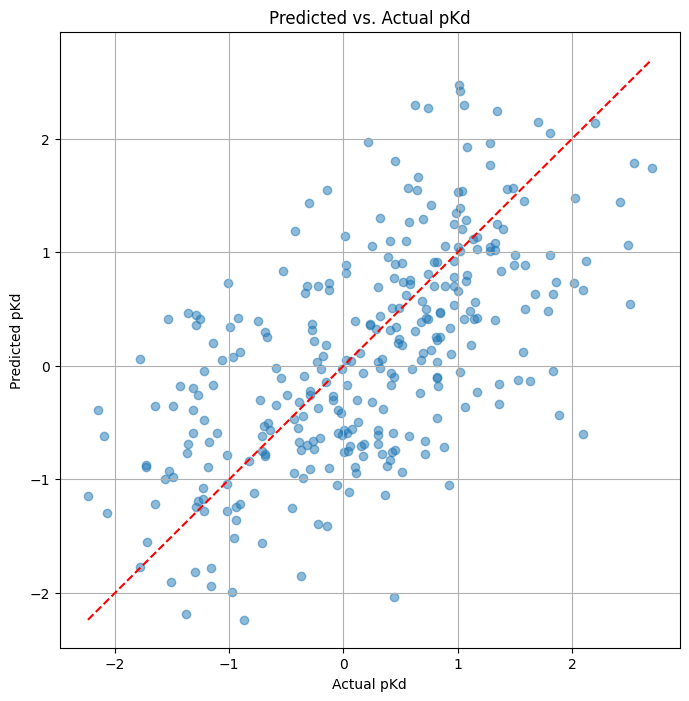

In [98]:
import matplotlib.pyplot as plt
import numpy as np

def plot_predictions_vs_actual(model, loader, device='cpu'):
    model.eval()
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            preds = model(batch).squeeze().cpu().numpy()
            targets = batch.y.squeeze().cpu().numpy()

            # Handle cases where preds or targets might be single values
            if preds.ndim == 0:
                preds = np.array([preds])
            if targets.ndim == 0:
                targets = np.array([targets])

            all_preds.extend(preds)
            all_targets.extend(targets)

    plt.figure(figsize=(8, 8))
    plt.scatter(all_targets, all_preds, alpha=0.5)
    plt.xlabel("Actual pKd")
    plt.ylabel("Predicted pKd")
    plt.title("Predicted vs. Actual pKd")
    plt.grid(True)

    # Add a diagonal line for perfect prediction
    min_val = min(min(all_targets), min(all_preds))
    max_val = max(max(all_targets), max(all_preds))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')

    plt.show()

# Use the trained model (debug_model) and the test_loader
plot_predictions_vs_actual(debug_model, test_loader, device='cpu')